# Training of UNET

The aim of this notebook is to train two times the UNET model, once using the training data with simple data augmentations (rotation by multiples of 90 degrees, horizontal and vertical flips), and the second time with said data augmentation and distortions added to the training data (non-uniform illumination and gaussian noise).

### $\bullet$ Importing libraries and utilitary functions

In [1]:
# Import python libraries.
import matplotlib.pyplot as plt
%matplotlib inline
import numpy as np
%load_ext autoreload
%autoreload 2
import os
os.environ['TF_CPP_MIN_LOG_LEVEL'] = '1'
import tensorflow
from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint

# Import utilitary functions and module defining the Unet model.
from utils import get_dataset_from_folders
from train_data_augmentation import make_train_generator
from unet import Unet
from plots import plot_history

In [2]:
# Set seeds of random number generators to guarantee reproducibility.
np.random.seed(1)
tensorflow.random.set_seed(2)

### $\bullet$ Setting size of the input image and different paths

In [3]:
# Shape of the inputs of the deep network.
images_shape = (256, 256, 1)

# Variables defining the path to the dataset.
train_input_path  = '../Dataset/train/input/'
train_output_path = '../Dataset/train/output/'
val_input_path    = '../Dataset/validation/input/'
val_output_path   = '../Dataset/validation/output/'
test_input_path   = '../Dataset/test/input/'
test_output_path  = '../Dataset/test/output/'

# Variable defining where models will be stored.
unet_original_save_path       = "../Models/Unet Original/"
unet_data_augmented_save_path = "../Models/Unet Data Augmented/"
unet_data_distorted_save_path = "../Models/Unet Data Distorted/"

### $\bullet$ Load images from the dataset

In [4]:
train_images, train_masks = get_dataset_from_folders(train_input_path, train_output_path, images_shape)
val_images, val_masks = get_dataset_from_folders(val_input_path, val_output_path, images_shape)
test_images, test_masks = get_dataset_from_folders(test_input_path, test_output_path, images_shape)

print(f'Training set contains {len(train_images)} images.')
print(f'Validation set contains {len(val_images)} images.')
print(f'Test set contains {len(test_images)} images.')

Training set contains 606 images.
Validation set contains 96 images.
Test set contains 510 images.


### $\bullet$ Training original model which used no data augmentations

In [5]:
# Setting up parameters used for training
number_epochs = 100
batch_size = 2
early_stopping = EarlyStopping(patience=50, verbose=1)
model_checkpoint = ModelCheckpoint(filepath=unet_original_save_path, save_weights_only=False, monitor='val_accuracy', mode='max', save_best_only=True)

# Building Unet model.
model = Unet(images_shape, show_summary=True)

Model: "model"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            [(None, 256, 256, 1) 0                                            
__________________________________________________________________________________________________
conv2d (Conv2D)                 (None, 256, 256, 16) 160         input_1[0][0]                    
__________________________________________________________________________________________________
conv2d_1 (Conv2D)               (None, 256, 256, 16) 2320        conv2d[0][0]                     
__________________________________________________________________________________________________
dropout (Dropout)               (None, 256, 256, 16) 0           conv2d_1[0][0]                   
______________________________________________________________________________________________

In [6]:
# Training
history = model.fit(train_images, train_masks, validation_data = (val_images, val_masks), batch_size = batch_size, epochs=number_epochs, callbacks=[early_stopping, model_checkpoint])

Train on 606 samples, validate on 96 samples
Epoch 1/100
604/606 [============================>.] - ETA: 0s - loss: 0.8820 - accuracy: 0.9413WARNING:tensorflow:From C:\Anaconda3\lib\site-packages\tensorflow_core\python\ops\resource_variable_ops.py:1786: calling BaseResourceVariable.__init__ (from tensorflow.python.ops.resource_variable_ops) with constraint is deprecated and will be removed in a future version.
Instructions for updating:
If using Keras pass *_constraint arguments to layers.
INFO:tensorflow:Assets written to: ../Models/Unet Original/assets
606/606 [==============================] - 30s 50ms/sample - loss: 0.8793 - accuracy: 0.9414 - val_loss: 0.0658 - val_accuracy: 0.9740
Epoch 2/100
606/606 [==============================] - 25s 41ms/sample - loss: 0.0653 - accuracy: 0.9752 - val_loss: 0.0502 - val_accuracy: 0.9807
Epoch 3/100
606/606 [==============================] - 24s 40ms/sample - loss: 0.0563 - accuracy: 0.9783 - val_loss: 0.0464 - val_accuracy: 0.9821
Epoch 4/10

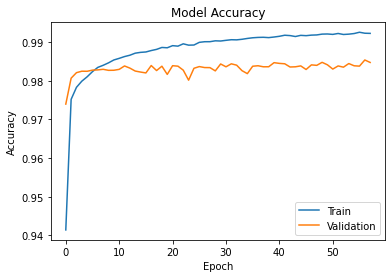

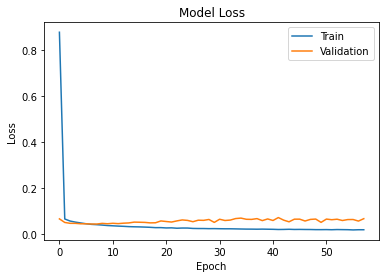

In [7]:
plot_history(history)

In [8]:
# Load best model saved by ModelCheckpoint
model = tensorflow.keras.models.load_model(unet_original_save_path)

# Evaluate best model
model.evaluate(test_images, test_masks);

510/510 [==============================] - 7s 14ms/sample - loss: 0.0359 - accuracy: 0.9905


### $\bullet$ Training model using images with simple data augmentations and no distortions

In [9]:
# Setting up parameters used for training
number_epochs = 200
batch_size = 2
steps_per_epoch = np.ceil(len(train_images)/batch_size).astype(np.uint)
early_stopping = EarlyStopping(patience=80, verbose=1)
model_checkpoint = ModelCheckpoint(filepath=unet_data_augmented_save_path, save_weights_only=False, monitor='val_accuracy', mode='max', save_best_only=True)

# Building Unet model.
model = Unet(images_shape, show_summary=False)

In [10]:
# Training
train_generator = make_train_generator(train_images, train_masks, batch_size=batch_size, custom_distortions=False)
history = model.fit(train_generator, validation_data=(val_images, val_masks), steps_per_epoch=steps_per_epoch, batch_size=batch_size, epochs=number_epochs, callbacks=[early_stopping, model_checkpoint])

  ...
    to  
  ['...']
Train for 303 steps, validate on 96 samples
Epoch 1/200
303/303 [==============================] - 24s 80ms/step - loss: 0.3757 - accuracy: 0.9504 - val_loss: 0.0562 - val_accuracy: 0.9795
Epoch 2/200
303/303 [==============================] - 21s 69ms/step - loss: 0.0592 - accuracy: 0.9772 - val_loss: 0.0473 - val_accuracy: 0.9827
Epoch 3/200
303/303 [==============================] - 21s 70ms/step - loss: 0.0526 - accuracy: 0.9798 - val_loss: 0.0447 - val_accuracy: 0.9830
Epoch 4/200
303/303 [==============================] - 21s 69ms/step - loss: 0.0495 - accuracy: 0.9808 - val_loss: 0.0444 - val_accuracy: 0.9832
Epoch 5/200
303/303 [==============================] - 21s 69ms/step - loss: 0.0477 - accuracy: 0.9814 - val_loss: 0.0430 - val_accuracy: 0.9837
Epoch 6/200
303/303 [==============================] - 21s 70ms/step - loss: 0.0459 - accuracy: 0.9819 - val_loss: 0.0415 - val_accuracy: 0.9839
Epoch 7/200
303/303 [==============================] - 21s 70

Epoch 41/200
303/303 [==============================] - 21s 70ms/step - loss: 0.0310 - accuracy: 0.9871 - val_loss: 0.0391 - val_accuracy: 0.9864
Epoch 42/200
303/303 [==============================] - 16s 54ms/step - loss: 0.0306 - accuracy: 0.9873 - val_loss: 0.0362 - val_accuracy: 0.9860
Epoch 43/200
303/303 [==============================] - 17s 55ms/step - loss: 0.0305 - accuracy: 0.9874 - val_loss: 0.0369 - val_accuracy: 0.9857
Epoch 44/200
303/303 [==============================] - 17s 55ms/step - loss: 0.0304 - accuracy: 0.9874 - val_loss: 0.0392 - val_accuracy: 0.9841
Epoch 45/200
303/303 [==============================] - 17s 56ms/step - loss: 0.0301 - accuracy: 0.9874 - val_loss: 0.0378 - val_accuracy: 0.9855
Epoch 46/200
303/303 [==============================] - 17s 56ms/step - loss: 0.0299 - accuracy: 0.9876 - val_loss: 0.0368 - val_accuracy: 0.9857
Epoch 47/200
303/303 [==============================] - 17s 56ms/step - loss: 0.0302 - accuracy: 0.9875 - val_loss: 0.0393 -

303/303 [==============================] - 18s 59ms/step - loss: 0.0258 - accuracy: 0.9893 - val_loss: 0.0406 - val_accuracy: 0.9848
Epoch 97/200
303/303 [==============================] - 18s 59ms/step - loss: 0.0258 - accuracy: 0.9892 - val_loss: 0.0386 - val_accuracy: 0.9855
Epoch 98/200
303/303 [==============================] - 18s 61ms/step - loss: 0.0254 - accuracy: 0.9894 - val_loss: 0.0395 - val_accuracy: 0.9854
Epoch 99/200
303/303 [==============================] - 19s 62ms/step - loss: 0.0255 - accuracy: 0.9893 - val_loss: 0.0408 - val_accuracy: 0.9857
Epoch 100/200
303/303 [==============================] - 18s 61ms/step - loss: 0.0256 - accuracy: 0.9893 - val_loss: 0.0389 - val_accuracy: 0.9858
Epoch 101/200
303/303 [==============================] - 18s 59ms/step - loss: 0.0256 - accuracy: 0.9893 - val_loss: 0.0389 - val_accuracy: 0.9856
Epoch 102/200
303/303 [==============================] - 19s 61ms/step - loss: 0.0254 - accuracy: 0.9894 - val_loss: 0.0401 - val_accur

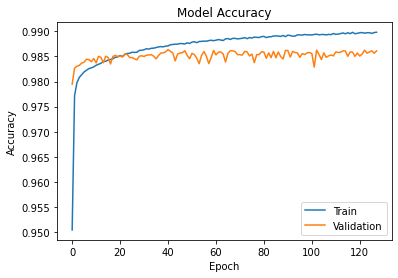

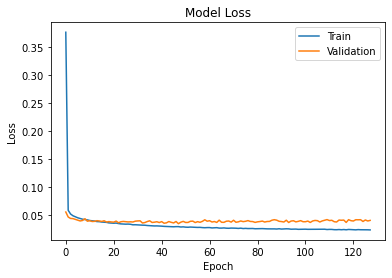

In [11]:
plot_history(history)

In [12]:
# Load best model saved by ModelCheckpoint
model = tensorflow.keras.models.load_model(unet_data_augmented_save_path)

# Evaluate best model
model.evaluate(test_images, test_masks);

510/510 [==============================] - 4s 8ms/sample - loss: 0.0244 - accuracy: 0.9908


### $\bullet$ Training model using images with simple data augmentations as well as distortions

In [13]:
# Setting up parameters used for training
number_epochs = 200
batch_size = 2
steps_per_epoch = np.ceil(len(train_images)/batch_size).astype(np.uint)
early_stopping = EarlyStopping(patience=150, verbose=1)
model_checkpoint = ModelCheckpoint(filepath=unet_data_distorted_save_path, save_weights_only=False, monitor='val_accuracy', mode='max', save_best_only=True)

# Building Unet model.
model = Unet(images_shape, show_summary=False)

In [14]:
# Training
train_generator = make_train_generator(train_images, train_masks, batch_size=batch_size, custom_distortions=True)
history = model.fit(train_generator, validation_data=(val_images, val_masks), steps_per_epoch=steps_per_epoch, batch_size=batch_size, epochs=number_epochs, callbacks=[early_stopping, model_checkpoint])

  ...
    to  
  ['...']
Train for 303 steps, validate on 96 samples
Epoch 1/200
303/303 [==============================] - 33s 109ms/step - loss: 0.5955 - accuracy: 0.8922 - val_loss: 0.1052 - val_accuracy: 0.9618
Epoch 2/200
303/303 [==============================] - 24s 80ms/step - loss: 0.2582 - accuracy: 0.9109 - val_loss: 0.0977 - val_accuracy: 0.9587
Epoch 3/200
303/303 [==============================] - 26s 86ms/step - loss: 0.2502 - accuracy: 0.9128 - val_loss: 0.1558 - val_accuracy: 0.9018
Epoch 4/200
303/303 [==============================] - 32s 104ms/step - loss: 0.2408 - accuracy: 0.9148 - val_loss: 0.0747 - val_accuracy: 0.9762
Epoch 5/200
303/303 [==============================] - 21s 70ms/step - loss: 0.2427 - accuracy: 0.9134 - val_loss: 0.1043 - val_accuracy: 0.9606
Epoch 6/200
303/303 [==============================] - 25s 81ms/step - loss: 0.2397 - accuracy: 0.9140 - val_loss: 0.1106 - val_accuracy: 0.9615
Epoch 7/200
303/303 [==============================] - 28s 

303/303 [==============================] - 27s 89ms/step - loss: 0.2226 - accuracy: 0.9188 - val_loss: 0.1078 - val_accuracy: 0.9774
Epoch 53/200
303/303 [==============================] - 27s 89ms/step - loss: 0.2286 - accuracy: 0.9164 - val_loss: 0.1287 - val_accuracy: 0.9579
Epoch 54/200
303/303 [==============================] - 26s 85ms/step - loss: 0.2258 - accuracy: 0.9174 - val_loss: 0.0965 - val_accuracy: 0.9743
Epoch 55/200
303/303 [==============================] - 26s 86ms/step - loss: 0.2226 - accuracy: 0.9193 - val_loss: 0.1075 - val_accuracy: 0.9775
Epoch 56/200
303/303 [==============================] - 29s 95ms/step - loss: 0.2258 - accuracy: 0.9173 - val_loss: 0.1150 - val_accuracy: 0.9691
Epoch 57/200
303/303 [==============================] - 25s 82ms/step - loss: 0.2221 - accuracy: 0.9196 - val_loss: 0.1279 - val_accuracy: 0.9640
Epoch 58/200
303/303 [==============================] - 25s 82ms/step - loss: 0.2209 - accuracy: 0.9197 - val_loss: 0.1019 - val_accuracy

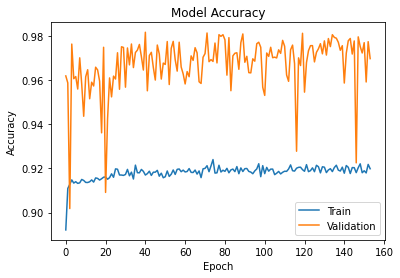

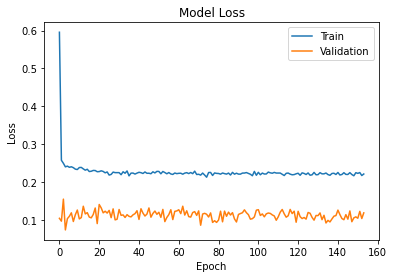

In [15]:
plot_history(history)

In [16]:
# Load best model saved by ModelCheckpoint
model = tensorflow.keras.models.load_model(unet_data_distorted_save_path)

# Evaluate best model
model.evaluate(test_images, test_masks);

510/510 [==============================] - 4s 7ms/sample - loss: 0.0806 - accuracy: 0.9872
